##### I. Изучение общей информации:
* [1. Изучение файлов с данными, получение общей информации](#1-section)

##### II. Подготовка данных:
* [1. Разбиение на выборки](#2-section)

##### III. Исследование моделей классификации:
* [1. Константная модель](#3-section)
* [2. Дисбаланс классов](#4-section)
* [3. Баланс классов](#5-section)
* [4. Изменение порога](#6-section)
* [5. Визуализация метрик](#7-section)

##### IV. Тестирование модели:
* [1. Проверка модели](#8-section)

##### [V. Общий вывод](#9-section)

## I. Изучение общей информации

<a id='1-section'></a>
### 1. Изучение файлов с данными, получение общей информации

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    f1_score, 
    precision_recall_curve, 
    roc_auc_score, 
    roc_curve,
    make_scorer
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb

In [2]:
# запишем датасет Churn.csv в 'churn'
try:
    churn = pd.read_csv('***/Churn.csv')
except:
    print('Ошибка при чтении файла!')
# посмотрим на первые 5 строк
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# общая информация о датафрейме
print(churn.shape)
churn.info()

(10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Tenure - это количество недвижимости у клиента. Значит Tenure должен иметь тип данных int64. Также в данном столбце присутствуют пропуски.

Пропуски могли возникнуть из-за разных причин. Данные могли затереться при копировании/скачивании/форматировании. А может клиенты специально не указали данные о количестве своей недвижимости. Заменим их на ноль. Посмотрим, как отработает модель. 

Но для начала приведем названия столбцов к нижнему регистру.

In [4]:
# приведем названия столбцов к нижнему регистру
churn.columns = churn.columns.str.lower()

In [5]:
# подробнее изучим данные
# создадим функцию, возвращающую детальную информацию о данных по столбцу
def get_info_column(data, column):
    print('{: ^}'.format("_" * (len("Числовое описание данных столбца") + len(column) + 1)))
    print()
    print("Числовое описание данных столбца", column)
    print()
    print(
        "Коэффициент корреляции Пирсона с целевым признаком: {:.2f}".format(
            data[column].corr(data["exited"])
        )
    )
    print()
    print(data[column].describe())
    print()
    if len(churn[column].unique()) > 2:
        if data[column].value_counts().min() != data[column].value_counts().max():
            print('Наиболее частотные значения столбца')
            print()
            print(data[column].value_counts().head())
            print()
            print('Наименее частотные значения столбца')
            print()
            print(data[column].value_counts().tail())
            print()
        print()
        if data[column].dtype in ['int64', 'float64']:
            if data.groupby(column)[column].count().max() != data.groupby(column)[column].count().min():
                print('Максимальные значения столбца')
                print()
                print(data.groupby(column)[column].count()[::-1].head())
                print()
                print('Минимальные значения столбца')
                print()
                print(data.groupby(column)[column].count().head()[::-1])
                print()
            print("Диаграмма размаха столбца", column)
            sns.boxplot(x=data[column])
            plt.show()
            print()
            print("Гистограмма для столбца", column)
            ax = sns.distplot(data[column])
            plt.show()
    else:
        print()
        print('Распределение данных столбца', column)
        print()
        print(data[column].value_counts())
        churn[column].value_counts().plot(kind='pie', subplots=True, figsize=(9,6), autopct='%1.1f%%')
        plt.show()

____________________________________________

Числовое описание данных столбца creditscore

Коэффициент корреляции Пирсона с целевым признаком: -0.03

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: creditscore, dtype: float64

Наиболее частотные значения столбца

850    233
678     63
655     54
705     53
667     53
Name: creditscore, dtype: int64

Наименее частотные значения столбца

419    1
417    1
373    1
365    1
401    1
Name: creditscore, dtype: int64


Максимальные значения столбца

creditscore
850    233
849      8
848      5
847      6
846      5
Name: creditscore, dtype: int64

Минимальные значения столбца

creditscore
363    1
359    1
358    1
351    1
350    5
Name: creditscore, dtype: int64

Диаграмма размаха столбца creditscore


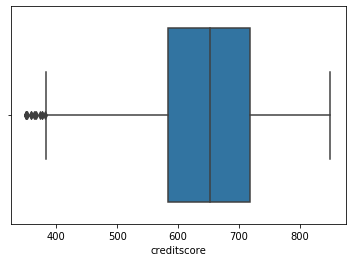


Гистограмма для столбца creditscore


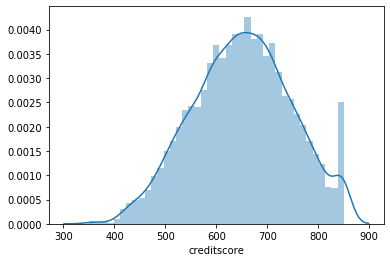

In [6]:
# применим функцию get_info_column() к столбцу 'creditscore'
get_info_column(churn,'creditscore')

Кредитный рейтинг имеет нормальное распределение. Заметим всплеск на значении 850. Это максимально возможное значение рейтинга. То есть 233 человека являются максимально добропорядочными с точки зрения кредитного доверия.

____________________________________

Числовое описание данных столбца age

Коэффициент корреляции Пирсона с целевым признаком: 0.29

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

Наиболее частотные значения столбца

37    478
38    477
35    474
36    456
34    447
Name: age, dtype: int64

Наименее частотные значения столбца

92    2
88    1
82    1
85    1
83    1
Name: age, dtype: int64


Максимальные значения столбца

age
92    2
88    1
85    1
84    2
83    1
Name: age, dtype: int64

Минимальные значения столбца

age
22    84
21    53
20    40
19    27
18    22
Name: age, dtype: int64

Диаграмма размаха столбца age


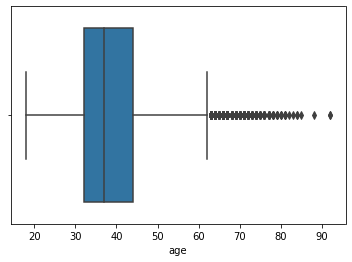


Гистограмма для столбца age


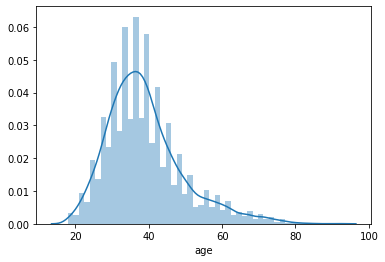

In [7]:
# применим функцию get_info_column() к столбцу 'age'
get_info_column(churn, 'age')

Данные по возрасту немного скошены вправо. Самому юному клиенту 18 лет, самому возрастному - 92 года. Возраст большинства клиентов находится в диапазоне 31 - 44 лет.

_______________________________________

Числовое описание данных столбца tenure

Коэффициент корреляции Пирсона с целевым признаком: -0.02

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

Наиболее частотные значения столбца

1.0    952
2.0    950
8.0    933
3.0    928
5.0    927
Name: tenure, dtype: int64

Наименее частотные значения столбца

4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64


Максимальные значения столбца

tenure
10.0    446
9.0     882
8.0     933
7.0     925
6.0     881
Name: tenure, dtype: int64

Минимальные значения столбца

tenure
4.0    885
3.0    928
2.0    950
1.0    952
0.0    382
Name: tenure, dtype: int64

Диаграмма размаха столбца tenure


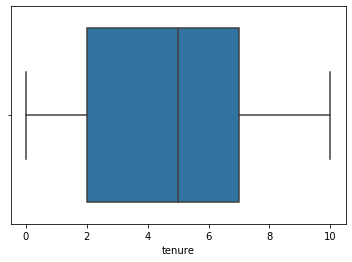


Гистограмма для столбца tenure


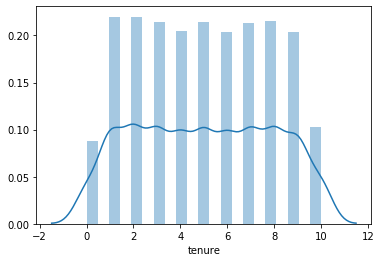

In [8]:
# применим функцию get_info_column() к столбцу 'tenure'
get_info_column(churn, 'tenure')

________________________________________

Числовое описание данных столбца balance

Коэффициент корреляции Пирсона с целевым признаком: 0.12

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64

Наиболее частотные значения столбца

0.00         3617
105473.74       2
130170.82       2
113063.83       1
80242.37        1
Name: balance, dtype: int64

Наименее частотные значения столбца

183555.24    1
137648.41    1
112689.95    1
115465.28    1
74681.90     1
Name: balance, dtype: int64


Максимальные значения столбца

balance
250898.09    1
238387.56    1
222267.63    1
221532.80    1
216109.88    1
Name: balance, dtype: int64

Минимальные значения столбца

balance
16893.59       1
14262.80       1
12459.19       1
3768.69        1
0.00        3617
Name: balance, dtype: int64

Диаграмма размаха столбца balance


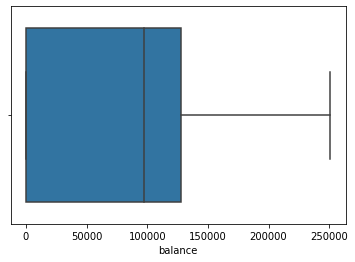


Гистограмма для столбца balance


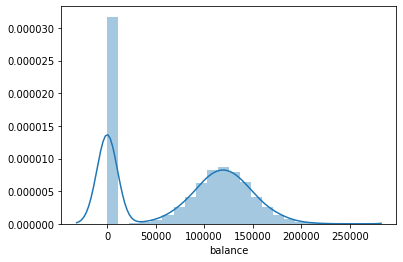

In [9]:
# применим функцию get_info_column() к столбцу 'balance'
get_info_column(churn, 'balance')

3617 человек имеют баланс равный 0. В остальных случаях распределение выглядит нормальным.

______________________________________________

Числовое описание данных столбца numofproducts

Коэффициент корреляции Пирсона с целевым признаком: -0.05

count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: numofproducts, dtype: float64

Наиболее частотные значения столбца

1    5084
2    4590
3     266
4      60
Name: numofproducts, dtype: int64

Наименее частотные значения столбца

1    5084
2    4590
3     266
4      60
Name: numofproducts, dtype: int64


Максимальные значения столбца

numofproducts
4      60
3     266
2    4590
1    5084
Name: numofproducts, dtype: int64

Минимальные значения столбца

numofproducts
4      60
3     266
2    4590
1    5084
Name: numofproducts, dtype: int64

Диаграмма размаха столбца numofproducts


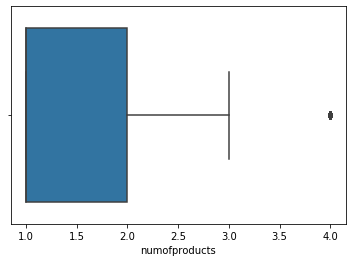


Гистограмма для столбца numofproducts


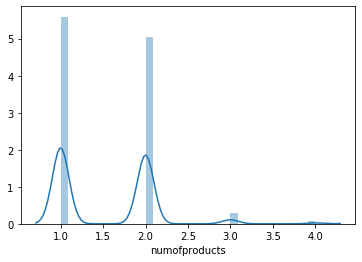

In [10]:
#применим функцию get_info_column() к столбцу 'numofproducts'
get_info_column(churn, 'numofproducts')

Заметим, что в данном столбце всего 4 уникальных значения. То есть 4 категории.

__________________________________________

Числовое описание данных столбца hascrcard

Коэффициент корреляции Пирсона с целевым признаком: -0.01

count    10000.00000
mean         0.70550
std          0.45584
min          0.00000
25%          0.00000
50%          1.00000
75%          1.00000
max          1.00000
Name: hascrcard, dtype: float64


Распределение данных столбца hascrcard

1    7055
0    2945
Name: hascrcard, dtype: int64


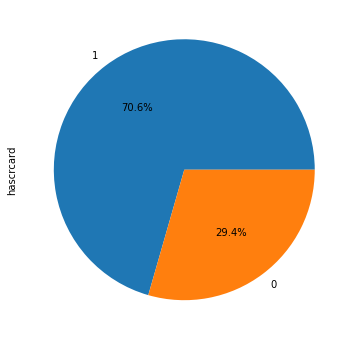

In [11]:
#применим функцию get_info_column() к столбцу 'hascrcard'
get_info_column(churn, 'hascrcard')

Это тоже категориальный признак - имеется ли кредитная карта.

_______________________________________________

Числовое описание данных столбца isactivemember

Коэффициент корреляции Пирсона с целевым признаком: -0.16

count    10000.000000
mean         0.515100
std          0.499797
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: isactivemember, dtype: float64


Распределение данных столбца isactivemember

1    5151
0    4849
Name: isactivemember, dtype: int64


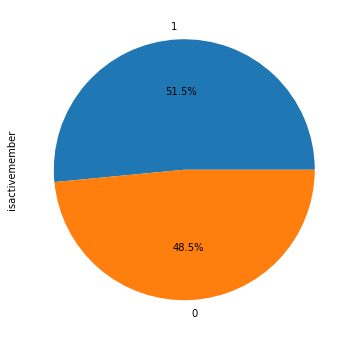

In [12]:
#применим функцию get_info_column() к столбцу 'isactivemember'
get_info_column(churn, 'isactivemember')

Аналогично признаку владения кредитной картой.

________________________________________________

Числовое описание данных столбца estimatedsalary

Коэффициент корреляции Пирсона с целевым признаком: 0.01

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimatedsalary, dtype: float64

Наиболее частотные значения столбца

24924.92     2
109029.72    1
182025.95    1
82820.85     1
30314.04     1
Name: estimatedsalary, dtype: int64

Наименее частотные значения столбца

158302.59    1
171037.63    1
43036.60     1
55034.02     1
104181.78    1
Name: estimatedsalary, dtype: int64


Максимальные значения столбца

estimatedsalary
199992.48    1
199970.74    1
199953.33    1
199929.17    1
199909.32    1
Name: estimatedsalary, dtype: int64

Минимальные значения столбца

estimatedsalary
106.67    1
96.27     1
91.75     1
90.07     1
11.58     1
Name: estimatedsalary, dtype: int64

Диаграмма размаха 

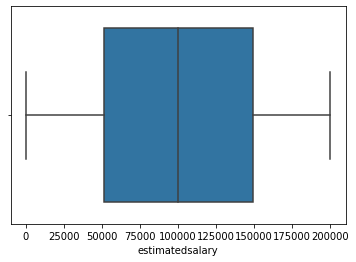


Гистограмма для столбца estimatedsalary


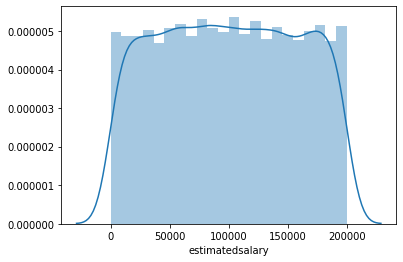

In [13]:
#применим функцию get_info_column() к столбцу 'estimatedsalary'
get_info_column(churn, 'estimatedsalary')

_______________________________________

Числовое описание данных столбца exited

Коэффициент корреляции Пирсона с целевым признаком: 1.00

count    10000.000000
mean         0.203700
std          0.402769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: exited, dtype: float64


Распределение данных столбца exited

0    7963
1    2037
Name: exited, dtype: int64


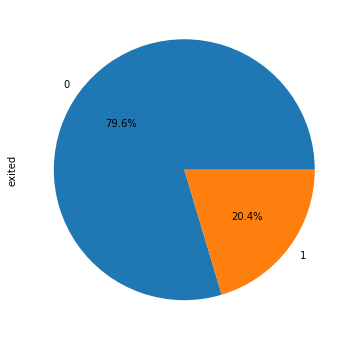

In [14]:
#применим функцию get_info_column() к столбцу 'exited'
get_info_column(churn, 'exited')

In [15]:
# построим матрицу корреляции всего df
churn.corr().style.background_gradient(cmap='PuBuGn')

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
rownumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
customerid,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
creditscore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
numofproducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
hascrcard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
isactivemember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimatedsalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Присутствует слабая прямая корреляция между возрастом и фактом ухода (0.285).

In [16]:
# заменим значения в столбце tenure на характерные
# для этого разделим значения кредитного рейтинга и возраста клиентов на группы
def get_group_creditscore(row):
    creditscore = row['creditscore']
    return creditscore // 50
def get_group_age(row):
    age = row['age']
    return age // 10

In [17]:
# создадим копию df
churn_up = churn.copy()

In [18]:
# заполним значения с помощью функции apply(), get_group_creditscore(), get_group_age()
churn_up['creditscore_level'] = churn_up.apply(get_group_creditscore, axis=1)
churn_up['age_level'] = churn_up.apply(get_group_age, axis=1)

In [19]:
# создадим функцию, которая по заданному df и столбцу, создавала бы сводную таблицу, в которой для каждой возрастной категории и 
# категории кредитного рейтинга считала бы среднее значение выбранного столбца
# и затем для каждого соответствия категорий возраста и кредитного рейтинга исходного df заполняла бы пропуск в данном 
# столбце из этой сводной таблицы
def fill_with_pivot_table(data, column):
    # создадим сводную таблицу, в которой для каждой марки и модели автомобиля считается среднее значение столбца column
    pivot_table = data.pivot_table(index=['creditscore_level', 'age_level'], values=column).astype(int)
    # создадим df, который является срезом data, состоящим из пропусков в столбце column
    df_nan = data.loc[data[column].isnull()]
    def change_values(row):
        creditscore_level = row['creditscore_level']
        age_level = row['age_level']
        # создадим конструкцию try/except на случай, если в pivot_table не найдется значения по двум категориям
        try:
            value = pivot_table.loc[(creditscore_level, age_level),:]
        except:
            value = np.nan
        return value    
    # заполним пропуски в df_nan с помощью функции change_values() и apply()  
    df_nan = df_nan.copy()
    df_nan[column] = df_nan.apply(change_values, axis=1)
    # теперь надо заменить значения в data из df_nan
    for i in df_nan.index:
        if i in data.index:
            data.loc[i,column] = df_nan.loc[i,column]

In [20]:
# применим функцию fill_with_pivot_table()
fill_with_pivot_table(churn_up, 'tenure')

In [21]:
# посмотрим на пропуски
churn_up.loc[churn_up['tenure'].isnull()]

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,creditscore_level,age_level
6443,6444,15764927,Rogova,753,France,Male,92,NaN,121513.31,1,0,1,195563.99,0,15,9


В данных остался только 1 пропуск. Мужчина 92 лет. Получим медианное значение для категории creditscore_level = 15 и возрастом не менее 70 лет.

In [22]:
round(churn_up.query('creditscore_level == 15 & age_level > 6')['tenure'].median())

6

In [23]:
# заменим пропуск на данное значение
churn_up = churn_up.fillna(
    round(churn_up.query("creditscore_level == 15 & age_level > 6")["tenure"].median())
)

In [24]:
# изменим тип данных в "tenure" на целочисленный
churn_up['tenure'] = churn_up['tenure'].astype('int64')

### Вывод

Изучили общую информацию о датафрейме:
 - названия столбцов привели к нижнему регистру;
 - нет пропусков, кроме столбца с количеством недвижимости "tenure";
 - добавили два столца - категории кредитного рейтинга и возраста. На их основании заменили пропуски в столбце "tenure";
 - есть категориальные признаки: "surname", "geography", "gender".

## II. Подготовка данных

<a id='2-section'></a>
### 1. Разбиение на выборки

Необходимо преобразовать категориальные признаки в численные. В этом нам поможет One-Hot Encoding (OHE). Учтём также, что факт ухода клиента не зависит от его фамилии, поэтому не будем работать с данным категориальным признаком. Также, как и признаки "rownumber", "customerid".

In [25]:
# воспользуемся функцией get_dummies()
churn_up = pd.get_dummies(churn_up.drop(['surname', 'rownumber', 'customerid','creditscore_level','age_level'], axis=1), drop_first=True)
churn_up.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [26]:
# вручную добавим столбцы по 'numofproducts'
churn_up[['numofproducts_1', 'numofproducts_2', 'numofproducts_3', 'numofproducts_4']] = pd.get_dummies(churn_up['numofproducts'])
churn_up = churn_up.drop('numofproducts', axis=1)
churn_up.head()

,creditscore,age,tenure,balance,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male,numofproducts_1,numofproducts_2,numofproducts_3,numofproducts_4
0,619,42,2,0.00,1,1,101348.88,1,0,0,0,1,0,0,0
1,608,41,1,83807.86,0,1,112542.58,0,0,1,0,1,0,0,0
2,502,42,8,159660.80,1,0,113931.57,1,0,0,0,0,0,1,0
3,699,39,1,0.00,0,0,93826.63,0,0,0,0,0,1,0,0
4,850,43,2,125510.82,1,1,79084.10,0,0,1,0,1,0,0,0


Все оставшиеся признаки значимы. Но в данных есть значения предполагаемой зарплаты - порядка сотен тысяч, а есть кредитный рейтинг - порядка нескольких сотен. Необходимо масштабировать признаки. Воспользуемся стандартизацией данных.

In [27]:
#разделим данные по признакам и целевому признаку
features = churn_up.drop('exited', axis=1)
target = churn_up['exited']
#сделаем 3 выборки: тренировочную, валидационную и тестовую в соотношении 60%, 20%, 20%
#сделаем тренировочную выборку
features_train, features_rest, target_train, target_rest = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)
#оставшиеся данные разделим пополам на валидационную и тестовую выборки
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, test_size=0.5, random_state=12345, stratify=target_rest)

In [28]:
#создадим объект структуры данных StandardScaler
scaler = StandardScaler()
#выберем признаки для стандартизации
numeric = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']
#сделаем копии выборок
features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()
#настроим на обучающей выборке
scaler.fit(features_train.loc[:, numeric])
#преобразуем обучающую и валидационную выборки
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])
features_train.head()

,creditscore,age,tenure,balance,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male,numofproducts_1,numofproducts_2,numofproducts_3,numofproducts_4
2837,-1.040434,0.953312,0.375384,0.774657,0,1,-0.119110,1,0,0,1,0,0,0
9925,0.454006,-0.095244,-0.349296,1.910540,1,1,-0.258658,0,0,0,1,0,0,0
8746,0.103585,-0.476537,1.100065,0.481608,0,1,1.422836,0,0,1,0,1,0,0
660,-0.184996,0.190726,0.013044,0.088439,1,1,-1.160427,1,0,0,1,0,0,0
3610,-0.720933,1.620574,-1.436316,0.879129,1,0,0.113236,0,0,0,1,0,0,0


### Вывод

Мы подготовили данные:
- воспользовались техникой One-Hot Encoding (OHE);
- разделили данные на тренировочную, валидационную и тестовую выборки с разбиением по признакам и целевому признаку;
- масштабировали данные методом стандартизации.

## III. Исследование моделей классификации

В данной работе будут исследованы три модели задачи классификации: 
- логистическая регрессия;
- решающее дерево;
- случайный лес.

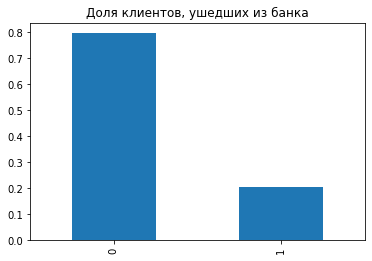

In [29]:
#посмотрим, насколько часто клиенты уходят из банка
churn_up['exited'].value_counts(normalize=True).plot(kind='bar', title='Доля клиентов, ушедших из банка')
plt.show()

Заметим, что клиентов, оставшихся в банке, примерно в 4 раза больше ушедших клиентов. Достаточно большая разница.

In [30]:
get_f1 = make_scorer(f1_score)

In [31]:
# напишем функцию для моделей с использованием GridSearchCV()
def get_best_model(model, parameters, x_train, x_valid, y_train, y_valid):
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring=get_f1)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    best_model.fit(x_train, y_train)
    predicted_valid = best_model.predict(x_valid)
    # вычислим значение полноты, точности и F1-меры нашей модели
    accuracy = accuracy_score(y_valid, predicted_valid)
    recall = recall_score(y_valid, predicted_valid)
    precision = precision_score(y_valid, predicted_valid)
    f1 = f1_score(y_valid, predicted_valid)
    # вычислим значение AUC-ROC
    probabilities_valid = best_model.predict_proba(x_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
    print('Лучшие параметры модели:', grid.best_params_)
    print()
    print('Матрица ошибок:')
    sns.heatmap(confusion_matrix(y_valid, predicted_valid), annot=True, fmt="d")
    plt.show()
    print()
    print()
    df = pd.DataFrame(data=[[accuracy], 
                            [recall], 
                            [precision], 
                            [f1], 
                            [auc_roc]], 
                      index=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'], 
                      columns=['Значения метрик'])
    return best_model, df

<a id='3-section'></a>
### 1. Константная модель

In [32]:
# определим точность предсказания константной модели
def dummy_model(x_train, x_test, y_train, y_test, constant):
    # константная модель, всегда предсказывающая значение по выбранной стратегии
    dummy = DummyClassifier(strategy='constant', constant=constant, random_state=12345)
    dummy.fit(x_train, y_train)
    pred_test = dummy.predict(x_test)
    # вычислим значение точности, полноты, F1-меры и AUC-ROC константной модели
    accuracy = accuracy_score(y_test, pred_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1 = f1_score(y_test, pred_test)
    dummy_probabilities_test = dummy.predict_proba(x_test)
    dummy_probabilities_one_test = dummy_probabilities_test[:, 1]
    auc_roc = roc_auc_score(y_test, dummy_probabilities_one_test)
    df = pd.DataFrame(data=[[accuracy], 
                            [recall], 
                            [precision], 
                            [f1], 
                            [auc_roc]], 
                      index=['accuracy', 'recall', 'precision', 'f1', 'auc_roc'], 
                      columns=['Значения метрик'])
    return df

In [33]:
dummy_0 = dummy_model(features_train, features_test, target_train, target_test, 0)
dummy_0

C:\Users\ilyae\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Значения метрик
accuracy,0.7965
recall,0.0000
precision,0.0000
f1,0.0000
auc_roc,0.5000


In [34]:
dummy_1 = dummy_model(features_train, features_test, target_train, target_test, 1)
dummy_1

,Значения метрик
accuracy,0.20350
recall,1.00000
precision,0.20350
f1,0.33818
auc_roc,0.50000


In [35]:
print('Лучшее значение f1-меры для константной модели: {:.2f}'.format(dummy_1.loc['f1','Значения метрик']))

Лучшее значение f1-меры для константной модели: 0.34


<a id='4-section'></a>
### 2. Дисбаланс классов

Лучшие параметры модели: {'C': 15, 'random_state': 12345}

Матрица ошибок:


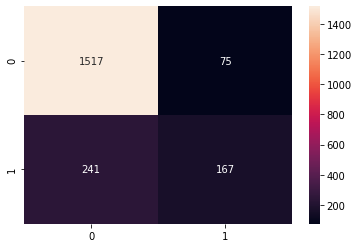



Wall time: 13 s


,Значения метрик
accuracy,0.842000
recall,0.409314
precision,0.690083
f1,0.513846
auc_roc,0.840659


In [36]:
%%time
# создадим словарь для логистической регрессии
param_log_reg = {
    'C'                 : list(range(1, 200, 2)),
    'random_state'      : [12345],
}
# используем функцию get_best_model()
log_reg_model, log_reg = get_best_model(LogisticRegression(solver='liblinear'), 
                                        param_log_reg, 
                                        features_train, 
                                        features_valid, 
                                        target_train, 
                                        target_valid)
log_reg

Лучшие параметры модели: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 12345}

Матрица ошибок:


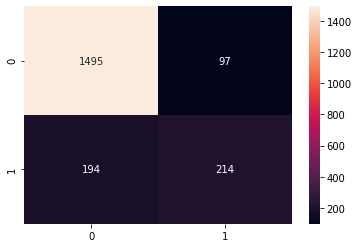



Wall time: 3min 13s


,Значения метрик
accuracy,0.854500
recall,0.524510
precision,0.688103
f1,0.595271
auc_roc,0.830639


In [37]:
%%time
# создадим словарь для решающего дерева
param_dec_tree = {
    'max_depth'         : list(range(1, 50, 2)),
    'min_samples_split' : list(range(2, 10, 1)),
    'min_samples_leaf'  : list(range(1, 10, 1)), 
    'random_state'      : [12345],
}
# используем функцию get_best_model()
dec_tree_model, dec_tree = get_best_model(DecisionTreeClassifier(), 
                                          param_dec_tree, 
                                          features_train, 
                                          features_valid, 
                                          target_train, 
                                          target_valid)
dec_tree

Лучшие параметры модели: {'max_depth': 16, 'n_estimators': 71, 'random_state': 12345}

Матрица ошибок:


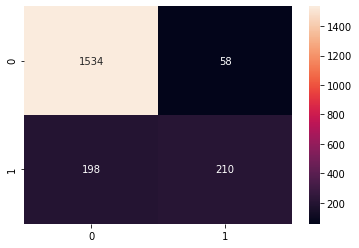



Wall time: 2min 7s


,Значения метрик
accuracy,0.872000
recall,0.514706
precision,0.783582
f1,0.621302
auc_roc,0.862280


In [38]:
%%time
# создадим словарь для случайного леса
param_rand_for = {
    'n_estimators'      : list(range(1, 100, 10)),
    'max_depth'         : list(range(1, 51, 5)), 
    'random_state'      : [12345],
}
# используем функцию get_best_model()
rand_for_model, rand_for = get_best_model(RandomForestClassifier(), 
                                          param_rand_for,
                                          features_train, 
                                          features_valid, 
                                          target_train, 
                                          target_valid)
rand_for

Лучшие параметры модели: {'max_depth': 21, 'n_estimators': 41}

Матрица ошибок:


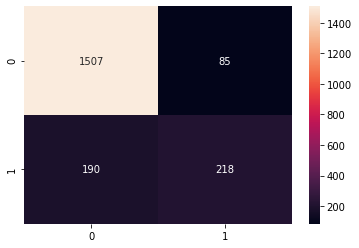



Wall time: 1min 23s


,Значения метрик
accuracy,0.862500
recall,0.534314
precision,0.719472
f1,0.613221
auc_roc,0.853863


In [39]:
%%time
# создадим словарь для xgboost
param_xgb = {
    "n_estimators": list(range(1, 101, 10)),
    "max_depth": list(range(1, 51, 10)),
}
# используем функцию get_best_model()
xgb_model, df_xgb = get_best_model(
    xgb.XGBClassifier(learning_rate=0.05, random_state=12345),
    param_xgb,
    features_train,
    features_valid,
    target_train,
    target_valid,
)
df_xgb

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 w

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[Lig

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 977, number of negative: 3823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203542 -> initscore=-1.364304
[LightGBM] [Info] Start training from score -1.364304
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 3823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203542 -> initscore=-1.364304
[LightGBM] [Info] Start training from score -1.364304


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 3823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203542 -> initscore=-1.364304
[LightGBM] [Info] Start training from score -1.364304


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203542 -> initscore=

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicit

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicit

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203542 -> initscore=

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=

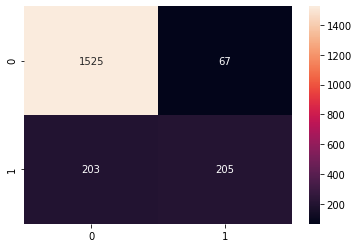



Wall time: 20.8 s


,Значения метрик
accuracy,0.865000
recall,0.502451
precision,0.753676
f1,0.602941
auc_roc,0.879171


In [40]:
%%time
# создадим словарь для lightgbm
param_lgb = {
    "n_estimators": list(range(1, 101, 10)),
    "max_depth"   : list(range(1, 51, 10)),
}
# используем функцию get_best_model()
lgb_model, df_lgb = get_best_model(
    lgb.LGBMClassifier(
        boosting_type="gbdt",
        objective="binary",
        learning_rate=0.05,
        feature_fraction=0.9,
        random_state=12345,
        silent=False,
    ),
    param_lgb,
    features_train,
    features_valid,
    target_train,
    target_valid,
)
df_lgb

0:	learn: 0.6731996	total: 68.3ms	remaining: 6.76s
50:	learn: 0.4210790	total: 134ms	remaining: 129ms
99:	learn: 0.3872363	total: 209ms	remaining: 0us
0:	learn: 0.6733710	total: 1.24ms	remaining: 123ms
50:	learn: 0.4231286	total: 77ms	remaining: 74ms
99:	learn: 0.3909143	total: 156ms	remaining: 0us
0:	learn: 0.6733186	total: 1.64ms	remaining: 163ms
50:	learn: 0.4263487	total: 79.1ms	remaining: 76ms
99:	learn: 0.3941888	total: 166ms	remaining: 0us
0:	learn: 0.6732922	total: 1.63ms	remaining: 161ms
50:	learn: 0.4202649	total: 75.2ms	remaining: 72.2ms
99:	learn: 0.3894061	total: 148ms	remaining: 0us
0:	learn: 0.6735490	total: 1.56ms	remaining: 155ms
50:	learn: 0.4225782	total: 77.2ms	remaining: 74.2ms
99:	learn: 0.3898163	total: 190ms	remaining: 0us
0:	learn: 0.6699468	total: 2.81ms	remaining: 278ms
50:	learn: 0.3748498	total: 108ms	remaining: 104ms
99:	learn: 0.3477796	total: 200ms	remaining: 0us
0:	learn: 0.6701703	total: 1.7ms	remaining: 168ms
50:	learn: 0.3770784	total: 88.1ms	remaini

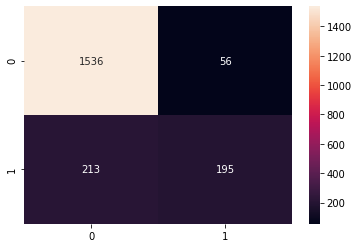



Wall time: 5min 13s


,Значения метрик
accuracy,0.865500
recall,0.477941
precision,0.776892
f1,0.591806
auc_roc,0.874340


In [41]:
%%time
# создадим словарь для catboost
param_ctb = {
    "depth": list(range(1, 17, 2)),
}
# используем функцию get_best_model()
ctb_model, df_ctb = get_best_model(
    ctb.CatBoostClassifier(iterations=100, learning_rate=0.05, verbose=50),
    param_ctb,
    features_train,
    features_valid,
    target_train,
    target_valid,
)
df_ctb

<a id='5-section'></a>
### 3. Баланс классов

Подготовим данные, чтобы они стали более сбалансированными.

In [42]:
# используем технику upsampling увеличения выборки
def upsample(features, target):
    # разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # скопируем несколько раз положительные объекты, создаем новую обучающую выборку
    features_upsampled = pd.concat([features_zeros] + [features_ones] * round(len(features_zeros) / len(features_ones)))
    target_upsampled = pd.concat([target_zeros] + [target_ones] * round(len(features_zeros) / len(features_ones)))
    # перемешиваем данные
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
# получили новую обучающую выборку
features_upsampled, target_upsampled = upsample(features_train, target_train)

Лучшие параметры модели: {'C': 1, 'random_state': 12345}

Матрица ошибок:


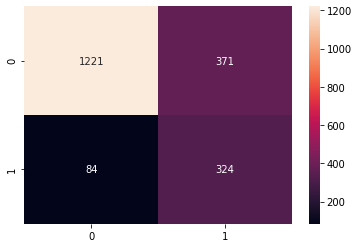



Wall time: 23.3 s


,Значения метрик
accuracy,0.772500
recall,0.794118
precision,0.466187
f1,0.587489
auc_roc,0.843719


In [43]:
%%time
# используем функцию get_best_model() для LogisticRegression()
log_reg_model_up, log_reg_up = get_best_model(LogisticRegression(solver='liblinear'), 
                                              param_log_reg, 
                                              features_upsampled, 
                                              features_valid, 
                                              target_upsampled, 
                                              target_valid)
log_reg_up

In [44]:
# для сравнения объединим таблицы
log_reg_up = pd.merge(log_reg_up, log_reg, suffixes=('_up', '_init'), on=log_reg.index).set_index('key_0')
log_reg_up.index.name = None

In [45]:
log_reg_up

,Значения метрик_up,Значения метрик_init
accuracy,0.772500,0.842000
recall,0.794118,0.409314
precision,0.466187,0.690083
f1,0.587489,0.513846
auc_roc,0.843719,0.840659


Лучшие параметры модели: {'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 12345}

Матрица ошибок:


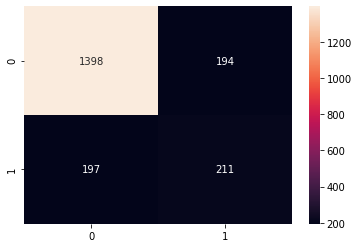



Wall time: 4min 15s


,Значения метрик_up,Значения метрик_init
accuracy,0.804500,0.854500
recall,0.517157,0.524510
precision,0.520988,0.688103
f1,0.519065,0.595271
auc_roc,0.698461,0.830639


In [46]:
%%time
# используем функцию get_best_model() для DecisionTreeClassifier()
dec_tree_model_up, dec_tree_up = get_best_model(DecisionTreeClassifier(), 
                                                param_dec_tree, 
                                                features_upsampled, 
                                                features_valid, 
                                                target_upsampled, 
                                                target_valid)
#для сравнения объединим таблицы
dec_tree_up = pd.merge(dec_tree_up, dec_tree, suffixes=('_up', '_init'), on=dec_tree.index).set_index('key_0')
dec_tree_up.index.name = None
dec_tree_up

Лучшие параметры модели: {'max_depth': 26, 'n_estimators': 61, 'random_state': 12345}

Матрица ошибок:


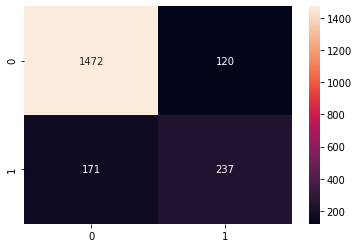



Wall time: 2min 32s


,Значения метрик_up,Значения метрик_init
accuracy,0.854500,0.872000
recall,0.580882,0.514706
precision,0.663866,0.783582
f1,0.619608,0.621302
auc_roc,0.858262,0.862280


In [47]:
%%time
#используем функцию get_best_model() для RandomForestClassifier()
rand_for_model_up, rand_for_up = get_best_model(RandomForestClassifier(), 
                                                param_rand_for, 
                                                features_upsampled, 
                                                features_valid, 
                                                target_upsampled, 
                                                target_valid)
#для сравнения объединим таблицы
rand_for_up = pd.merge(rand_for_up, rand_for, suffixes=('_up', '_init'), on=rand_for.index).set_index('key_0')
rand_for_up.index.name = None
rand_for_up

Лучшие параметры модели: {'max_depth': 31, 'n_estimators': 91}

Матрица ошибок:


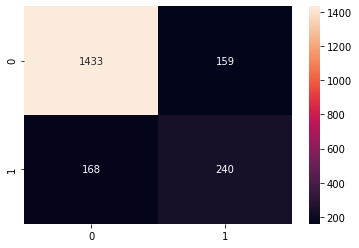

,Значения метрик
accuracy,0.836500
recall,0.588235
precision,0.601504
f1,0.594796
auc_roc,0.853825


In [48]:
# используем функцию get_best_model()
xgb_model_up, df_xgb_up = get_best_model(
    xgb.XGBClassifier(learning_rate=0.05, random_state=12345),
    param_xgb,
    features_upsampled,
    features_valid,
    target_upsampled,
    target_valid,
)
df_xgb_up

In [49]:
#для сравнения объединим таблицы
df_xgb_up = pd.merge(df_xgb_up, df_xgb, suffixes=('_up', '_init'), on=df_xgb.index).set_index('key_0')
df_xgb_up.index.name = None
df_xgb_up

,Значения метрик_up,Значения метрик_init
accuracy,0.836500,0.862500
recall,0.588235,0.534314
precision,0.601504,0.719472
f1,0.594796,0.613221
auc_roc,0.853825,0.853863


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 3910, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505691 -> initscore=0.022764
[LightGBM] [Info] Start training from score 0.022764
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 wi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore=0.022502
[LightGBM] [Info] Start training from score 0.022502
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[Lig

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 3910, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505691 -> initscore=0.022764
[LightGBM] [Info] Start training from score 0.022764
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the ove

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505755 -> initscore=0.023019
[LightGBM] [Info] Start training from score 0.023019
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[Lig

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505755 -> initscore=0.023019
[LightGBM] [Info] Start training from score 0.023019
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the ove

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505755 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505691 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505755 -> initscore=0.023019
[LightGBM] [Info] Start training from score 0.023019
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore=0.022502
[LightGBM] [Info] Start training from score 0.022502
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore=0.022502
[LightGBM] [Info] Start training from score 0.022502
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505755 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505755 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore=0.022502
[LightGBM] [Info] Start training from score 0.022502
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore=0.022502
[LightGBM] [Info] Start training from score 0.022502
[

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore=0.022502
[LightGBM] [Info] Start training from score 0.022502
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore=0.022502
[LightGBM] [Info] Start training from score 0.022502
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505755 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505691 -> initscore=0.022764
[LightGBM] [Info] Start training from score 0.022764
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505755 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505691 -> initscore=0.022764
[LightGBM] [Info] Start training from score 0.022764
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7732, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505691 -> initscore=0.022764
[LightGBM] [Info] Start training from score 0.022764
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3911, number of negative: 3822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505755 -> initscore

[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore=0.022502
[LightGBM] [Info] Start training from score 0.022502
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
A

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3910, number of negative: 3823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7733, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505625 -> initscore

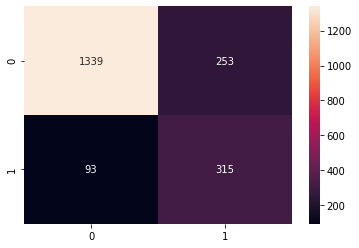

,Значения метрик
accuracy,0.827000
recall,0.772059
precision,0.554577
f1,0.645492
auc_roc,0.878658


In [50]:
# используем функцию get_best_model()
lgb_model_up, df_lgb_up = get_best_model(
    lgb.LGBMClassifier(
        boosting_type="gbdt",
        objective="binary",
        learning_rate=0.05,
        feature_fraction=0.9,
        random_state=12345,
        silent=False,
    ),
    param_lgb,
    features_upsampled,
    features_valid,
    target_upsampled,
    target_valid,
)
df_lgb_up

In [51]:
#для сравнения объединим таблицы
df_lgb_up = pd.merge(df_lgb_up, df_lgb, suffixes=('_up', '_init'), on=df_lgb.index).set_index('key_0')
df_lgb_up.index.name = None
df_lgb_up

,Значения метрик_up,Значения метрик_init
accuracy,0.827000,0.865000
recall,0.772059,0.502451
precision,0.554577,0.753676
f1,0.645492,0.602941
auc_roc,0.878658,0.879171


0:	learn: 0.6864193	total: 1.96ms	remaining: 194ms
50:	learn: 0.5556938	total: 95.2ms	remaining: 91.5ms
99:	learn: 0.5230803	total: 184ms	remaining: 0us
0:	learn: 0.6861476	total: 2.02ms	remaining: 200ms
50:	learn: 0.5574025	total: 123ms	remaining: 118ms
99:	learn: 0.5252025	total: 235ms	remaining: 0us
0:	learn: 0.6862848	total: 1.72ms	remaining: 170ms
50:	learn: 0.5569130	total: 71.8ms	remaining: 69ms
99:	learn: 0.5241800	total: 142ms	remaining: 0us
0:	learn: 0.6862977	total: 1.45ms	remaining: 144ms
50:	learn: 0.5550505	total: 82.9ms	remaining: 79.7ms
99:	learn: 0.5225379	total: 192ms	remaining: 0us
0:	learn: 0.6859797	total: 1.95ms	remaining: 194ms
50:	learn: 0.5532692	total: 116ms	remaining: 111ms
99:	learn: 0.5199124	total: 202ms	remaining: 0us
0:	learn: 0.6803939	total: 2.05ms	remaining: 203ms
50:	learn: 0.5004778	total: 113ms	remaining: 109ms
99:	learn: 0.4694970	total: 233ms	remaining: 0us
0:	learn: 0.6801674	total: 2.1ms	remaining: 208ms
50:	learn: 0.5013278	total: 139ms	remain

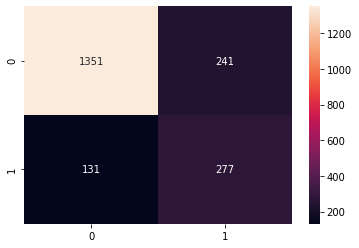

,Значения метрик
accuracy,0.814000
recall,0.678922
precision,0.534749
f1,0.598272
auc_roc,0.852036


In [52]:
# используем функцию get_best_model()
ctb_model_up, df_ctb_up = get_best_model(
    ctb.CatBoostClassifier(iterations=100, learning_rate=0.05, verbose=50),
    param_ctb,
    features_upsampled,
    features_valid,
    target_upsampled,
    target_valid,
)
df_ctb_up

In [53]:
#для сравнения объединим таблицы
df_ctb_up = pd.merge(df_ctb_up, df_ctb, suffixes=('_up', '_init'), on=df_ctb.index).set_index('key_0')
df_ctb_up.index.name = None
df_ctb_up

,Значения метрик_up,Значения метрик_init
accuracy,0.814000,0.865500
recall,0.678922,0.477941
precision,0.534749,0.776892
f1,0.598272,0.591806
auc_roc,0.852036,0.874340


In [54]:
# используем технику downsampling уменьшения выборки
def downsample(features, target):
    # разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # случайным образом отбросим часть отрицательных объектов
    fraction = round(len(features_ones) / len(features_zeros), 2)
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    # перемешиваем данные
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled
# получили новую обучающую выборку
features_downsampled, target_downsampled = downsample(features_train, target_train)

Лучшие параметры модели: {'C': 3, 'random_state': 12345}

Матрица ошибок:


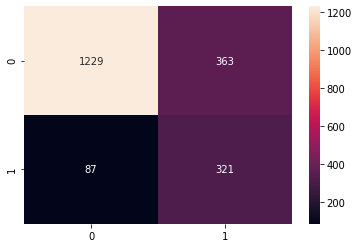



Wall time: 5.98 s


,Значения метрик_down,Значения метрик_up,Значения метрик_init
accuracy,0.775000,0.772500,0.842000
recall,0.786765,0.794118,0.409314
precision,0.469298,0.466187,0.690083
f1,0.587912,0.587489,0.513846
auc_roc,0.842221,0.843719,0.840659


In [64]:
%%time
# используем функцию get_best_model() для LogisticRegression()
log_reg_model_down, log_reg_down = get_best_model(LogisticRegression(solver='liblinear'), 
                                                  param_log_reg,
                                                  features_downsampled, 
                                                  features_valid, 
                                                  target_downsampled, 
                                                  target_valid)
# для сравнения объединим таблицы
log_reg_down = pd.merge(log_reg_down, log_reg_up, on=log_reg_up.index).set_index('key_0')
log_reg_down.index.name = None
log_reg_down.rename(columns={'Значения метрик' : 'Значения метрик_down'}, inplace=True)
log_reg_down

Лучшие параметры модели: {'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2, 'random_state': 12345}

Матрица ошибок:


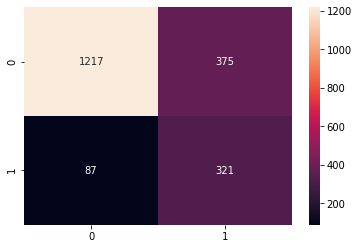



Wall time: 1min 37s


,Значения метрик_down,Значения метрик_up,Значения метрик_init
accuracy,0.769000,0.804500,0.854500
recall,0.786765,0.517157,0.524510
precision,0.461207,0.520988,0.688103
f1,0.581522,0.519065,0.595271
auc_roc,0.845149,0.698461,0.830639


In [65]:
%%time
# используем функцию get_best_model() для DecisionTreeClassifier()
dec_tree_model_down, dec_tree_down = get_best_model(DecisionTreeClassifier(), 
                                                    param_dec_tree, 
                                                    features_downsampled, 
                                                    features_valid, 
                                                    target_downsampled, 
                                                    target_valid)
# для сравнения объединим таблицы
dec_tree_down = pd.merge(dec_tree_down, dec_tree_up, on=dec_tree_up.index).set_index('key_0')
dec_tree_down.index.name = None
dec_tree_down.rename(columns={'Значения метрик' : 'Значения метрик_down'}, inplace=True)
dec_tree_down

Лучшие параметры модели: {'max_depth': 11, 'n_estimators': 91, 'random_state': 12345}

Матрица ошибок:


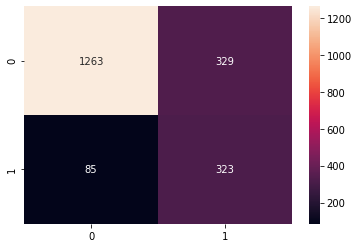



Wall time: 1min 9s


,Значения метрик_down,Значения метрик_up,Значения метрик_init
accuracy,0.793000,0.854500,0.872000
recall,0.791667,0.580882,0.514706
precision,0.495399,0.663866,0.783582
f1,0.609434,0.619608,0.621302
auc_roc,0.859119,0.858262,0.862280


In [66]:
%%time
#используем функцию get_best_model() для RandomForestClassifier()
rand_for_model_down, rand_for_down = get_best_model(RandomForestClassifier(), 
                                                    param_rand_for, 
                                                    features_downsampled, 
                                                    features_valid, 
                                                    target_downsampled, 
                                                    target_valid)
#для сравнения объединим таблицы
rand_for_down = pd.merge(rand_for_down, rand_for_up, on=rand_for_up.index).set_index('key_0')
rand_for_down.index.name = None
rand_for_down.rename(columns={'Значения метрик' : 'Значения метрик_down'}, inplace=True)
rand_for_down

Лучшие параметры модели: {'max_depth': 21, 'n_estimators': 41}

Матрица ошибок:


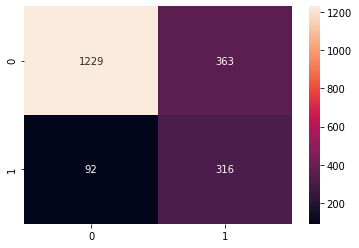

,Значения метрик_down,Значения метрик_up,Значения метрик_init
accuracy,0.772500,0.836500,0.862500
recall,0.774510,0.588235,0.534314
precision,0.465390,0.601504,0.719472
f1,0.581417,0.594796,0.613221
auc_roc,0.850560,0.853825,0.853863


In [67]:
# используем функцию get_best_model()
xgb_model_down, df_xgb_down = get_best_model(
    xgb.XGBClassifier(learning_rate=0.05, random_state=12345),
    param_xgb,
    features_downsampled,
    features_valid,
    target_downsampled,
    target_valid,
)
# для сравнения объединим таблицы
df_xgb_down = pd.merge(df_xgb_down, df_xgb_up, on=df_xgb_up.index).set_index('key_0')
df_xgb_down.index.name = None
df_xgb_down.rename(columns={'Значения метрик' : 'Значения метрик_down'}, inplace=True)
df_xgb_down

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 978, number of negative: 993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496195 -> initscore=-0.015221
[LightGBM] [Info] Start training from score -0.015221
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [I

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 978, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495943 -> initscore=-0.016228
[LightGBM] [Info] Start training from score -0.016228
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [I

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 978, number of negative: 993
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496195 -> initscore=-0.015221
[LightGBM] [Info] Start training from score -0.015221
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 wi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [I

[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496195 -> initscore=-0.015221
[LightGBM] [Info] Start training from score -0.015221
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496195 -> initscore=-0.015221
[LightGBM] [Info] Start training from score -0.015221
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495943 -> initscore=-0.016228
[LightGBM] [Info] Start training from score -0.016228
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496195 -> initscore=-0.015221
[LightGBM] [Info] Start training from score -0.015221
[

[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495943 -> initscore=-0.016228
[LightGBM] [Info] Start training from score -0.016228
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495943 -> initscore=-0.016228
[LightGBM] [Info] Start training from score -0.016228
[

[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 978, number of negative: 993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496195 -> initscore=-0.015221
[LightGBM] [Info] Start training from score -0.015221
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[

[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495687 -> initscore=-0.017251
[LightGBM] [Info] Start training from score -0.017251
[

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496195 -> initscore=-0.015221
[LightGBM] [Info] Start training from score -0.015221
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 977, number of negative: 994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 1971, number of used features: 14
[

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 2464, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495942 -> initscore=-0.016234
[LightGBM] [Info] Start training from score -0.016234
Лучшие параметры модели: {'max_depth': 11, 'n_estimators': 31}

Матрица ошибок:


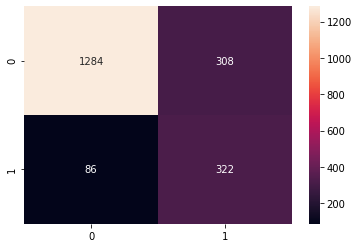

,Значения метрик_down,Значения метрик_up,Значения метрик_init
accuracy,0.803000,0.827000,0.865000
recall,0.789216,0.772059,0.502451
precision,0.511111,0.554577,0.753676
f1,0.620424,0.645492,0.602941
auc_roc,0.870582,0.878658,0.879171


In [68]:
# используем функцию get_best_model()
lgb_model_down, df_lgb_down = get_best_model(
    lgb.LGBMClassifier(
        boosting_type="gbdt",
        objective="binary",
        learning_rate=0.05,
        feature_fraction=0.9,
        random_state=12345,
        silent=False,
    ),
    param_lgb,
    features_downsampled,
    features_valid,
    target_downsampled,
    target_valid,
)
# для сравнения объединим таблицы
df_lgb_down = pd.merge(df_lgb_down, df_lgb_up, on=df_lgb_up.index).set_index('key_0')
df_lgb_down.index.name = None
df_lgb_down.rename(columns={'Значения метрик' : 'Значения метрик_down'}, inplace=True)
df_lgb_down

0:	learn: 0.6856446	total: 893us	remaining: 88.5ms
50:	learn: 0.5471776	total: 39.2ms	remaining: 37.6ms
99:	learn: 0.5144137	total: 85ms	remaining: 0us
0:	learn: 0.6859437	total: 949us	remaining: 94ms
50:	learn: 0.5526628	total: 41ms	remaining: 39.4ms
99:	learn: 0.5181124	total: 86.4ms	remaining: 0us
0:	learn: 0.6865511	total: 1.02ms	remaining: 101ms
50:	learn: 0.5577333	total: 49.3ms	remaining: 47.3ms
99:	learn: 0.5260941	total: 98.4ms	remaining: 0us
0:	learn: 0.6856239	total: 919us	remaining: 91ms
50:	learn: 0.5518028	total: 44.4ms	remaining: 42.7ms
99:	learn: 0.5203725	total: 94.5ms	remaining: 0us
0:	learn: 0.6859228	total: 885us	remaining: 87.6ms
50:	learn: 0.5537984	total: 37.8ms	remaining: 36.3ms
99:	learn: 0.5202164	total: 78ms	remaining: 0us
0:	learn: 0.6795900	total: 1.25ms	remaining: 124ms
50:	learn: 0.4962027	total: 61.7ms	remaining: 59.2ms
99:	learn: 0.4658234	total: 120ms	remaining: 0us
0:	learn: 0.6799577	total: 1.5ms	remaining: 148ms
50:	learn: 0.4977814	total: 62.3ms	re

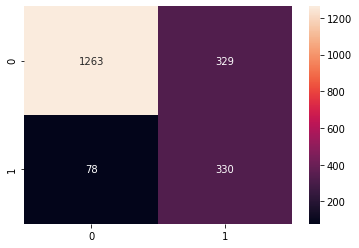



Wall time: 5min 32s


,Значения метрик_down,Значения метрик_up,Значения метрик_init
accuracy,0.796500,0.814000,0.865500
recall,0.808824,0.678922,0.477941
precision,0.500759,0.534749,0.776892
f1,0.618557,0.598272,0.591806
auc_roc,0.871090,0.852036,0.874340


In [69]:
%%time
# используем функцию get_best_model()
ctb_model_down, df_ctb_down = get_best_model(
    ctb.CatBoostClassifier(iterations=100, learning_rate=0.05, verbose=50),
    param_ctb,
    features_downsampled,
    features_valid,
    target_downsampled,
    target_valid,
)
# для сравнения объединим таблицы
df_ctb_down = pd.merge(df_ctb_down, df_ctb_up, on=df_ctb_up.index).set_index('key_0')
df_ctb_down.index.name = None
df_ctb_down.rename(columns={'Значения метрик' : 'Значения метрик_down'}, inplace=True)
df_ctb_down

In [80]:
df_ctb_down

,Значения метрик_down,Значения метрик_up,Значения метрик_init
accuracy,0.796500,0.814000,0.865500
recall,0.808824,0.678922,0.477941
precision,0.500759,0.534749,0.776892
f1,0.618557,0.598272,0.591806
auc_roc,0.871090,0.852036,0.874340


Лучшее значение F1-меры оказалось равным `0.6455`. Это значение удалось достичь для модели LightGBM с помощью техники upsampling. Техника downsampling для LightGBM дала результат `0.6204` и для CatBoost - `0.6186`.

Случайный лес показал результат немного хуже - `0.6213`.

Решающее дерево и логистическая регрессия показали себя хуже: `0.5952` и `0.5873` соответственно.

<a id='6-section'></a>
### 4. Изменение порога

По умолчанию значение порога равно 0.5. Что, если мы поменяем это значение, может быть наша модель станет лучше?

In [148]:
# напишем функцию, которая принимает на вход модель и возвращает значение f1-меры и значение порога. 
def get_f1_threshold(model):
    # воспользуемся функцией predict_proba()
    predicted_valid = model.predict(features_valid)
    # значения вероятности классов для валидационной выборки
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    # переберем значения порогов от 0 до 1 с шагом в 0.01
    best_f1 = 0
    for threshold in np.arange(0, 1, 0.01):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    print('Лучшее значение F1-меры - {:.4f} - достигается при значении порога - {:.2f}'.format(best_f1, best_threshold))
    predicted_valid = probabilities_one_valid > best_threshold
    return best_f1, best_threshold, probabilities_valid, probabilities_one_valid, predicted_valid

In [162]:
(
    f1_lgb_down,
    threshold_lgb_down,
    probabilities_valid_lgb_down,
    probabilities_one_valid_lgb_down,
    predicted_valid_lgb_down,
) = get_f1_threshold(lgb_model_down)

Лучшее значение F1-меры - 0.6504 - достигается при значении порога - 0.61


In [163]:
(
    f1_lgb_up,
    threshold_lgb_up,
    probabilities_valid_lgb_up,
    probabilities_one_valid_lgb_up,
    predicted_valid_lgb_up,
) = get_f1_threshold(lgb_model_up)

Лучшее значение F1-меры - 0.6489 - достигается при значении порога - 0.55


In [164]:
(
    f1_ctb_down,
    threshold_ctb_down,
    probabilities_valid_ctb_down,
    probabilities_one_valid_ctb_down,
    predicted_valid_ctb_down,
) = get_f1_threshold(ctb_model_down)

Лучшее значение F1-меры - 0.6586 - достигается при значении порога - 0.59


In [175]:
(
    f1_xgb,
    threshold_xgb,
    probabilities_valid_xgb,
    probabilities_one_valid_xgb,
    predicted_valid_xgb,
) = get_f1_threshold(xgb_model)

Лучшее значение F1-меры - 0.6278 - достигается при значении порога - 0.45


In [165]:
(
    f1_rand_for,
    threshold_rand_for,
    probabilities_valid_rand_for,
    probabilities_one_valid_rand_for,
    predicted_valid_rand_for,
) = get_f1_threshold(rand_for_model)

Лучшее значение F1-меры - 0.6460 - достигается при значении порога - 0.33


Таким образом, нам удалось достичь значения F1-меры `0.6586` на валидационной выборке при значении порога - `0.59` для модели CatBoost с помощью техники downsampling.

In [167]:
df_ctb_down['Значения метрик_threshold'] = [accuracy_score(target_valid, predicted_valid_ctb_down),
                                           recall_score(target_valid, predicted_valid_ctb_down),
                                           precision_score(target_valid, predicted_valid_ctb_down),
                                           f1_score(target_valid, predicted_valid_ctb_down),
                                           roc_auc_score(target_valid, probabilities_one_valid_ctb_down)]

<a id='7-section'></a>
### 5. Визуализация метрик

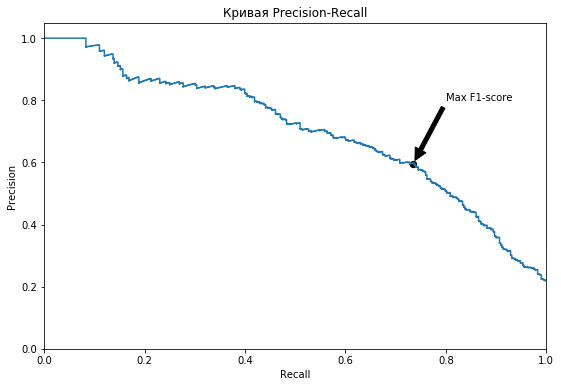

In [168]:
#построим PR-кривую
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid_ctb_down[:, 1])

plt.figure(figsize=(9, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.scatter(df_ctb_down.loc['recall', 'Значения метрик_threshold'], df_ctb_down.loc['precision', 'Значения метрик_threshold'], \
            color='black', s=40)
plt.annotate('Max F1-score', xy=(df_ctb_down.loc['recall', 'Значения метрик_threshold'], \
                                 df_ctb_down.loc['precision', 'Значения метрик_threshold']), xytext=(0.8, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05)
             )
plt.show()

In [170]:
# воспользуемся функцией predict_proba() для лучшей модели логистической регрессии
predicted_valid_log_reg = log_reg_model_down.predict(features_valid)
# значения вероятности классов для валидационной выборки
probabilities_valid_log_reg = log_reg_model_down.predict_proba(features_valid)
probabilities_one_valid_log_reg = probabilities_valid_log_reg[:, 1]
round(f1_score(target_valid, predicted_valid_log_reg),4)

0.5879

In [172]:
# воспользуемся функцией predict_proba() для лучшей модели решающего дерева
predicted_valid_dec_tree = dec_tree_model.predict(features_valid)
# значения вероятности классов для валидационной выборки
probabilities_valid_dec_tree = dec_tree_model.predict_proba(features_valid)
probabilities_one_valid_dec_tree = probabilities_valid_dec_tree[:, 1]
round(f1_score(target_valid, predicted_valid_dec_tree),4)

0.5953

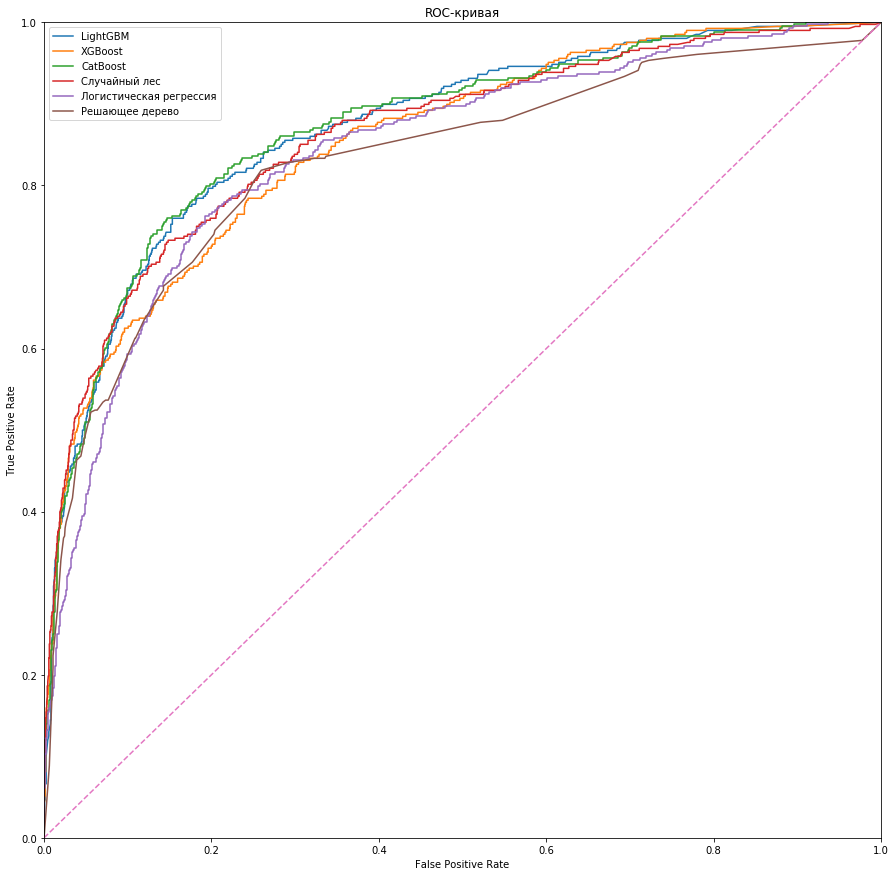

In [195]:
# построим ROC-кривую
# для сравнения на графике представлена ROC-кривая случайной модели
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(
    target_valid, probabilities_one_valid_lgb_down)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(
    target_valid, probabilities_one_valid_xgb)
fpr_ctb, tpr_ctb, thresholds_ctb = roc_curve(
    target_valid, probabilities_one_valid_ctb_down)
fpr_rand_for, tpr_rand_for, thresholds_rand_for = roc_curve(
    target_valid, probabilities_one_valid_rand_for)
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(
    target_valid, probabilities_one_valid_log_reg)
fpr_dec_tree, tpr_dec_tree, thresholds_dec_tree = roc_curve(
    target_valid, probabilities_one_valid_dec_tree)
plt.figure(figsize=(15, 15))
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_ctb, tpr_ctb, label='CatBoost')
plt.plot(fpr_rand_for, tpr_rand_for, label='Случайный лес')
plt.plot(fpr_log_reg, tpr_log_reg, label='Логистическая регрессия')
plt.plot(fpr_dec_tree, tpr_dec_tree, label='Решающее дерево')
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Вывод

В результате исследования моделей классификации было выявлено, что лучшая модель для данной задачи - CatBoost. Максимальное значение F1-меры такой модели равно `0.6586`. Оно получается после изменения порога до значения `0.59`.

## IV. Тестирование модели

<a id='8-section'></a>
### 1. Проверка модели

In [190]:
df_ctb_down

,Значения метрик_down,Значения метрик_up,Значения метрик_init,Значения метрик_threshold
accuracy,0.796500,0.814000,0.865500,0.844500
recall,0.808824,0.678922,0.477941,0.735294
precision,0.500759,0.534749,0.776892,0.596421
f1,0.618557,0.598272,0.591806,0.658617
auc_roc,0.871090,0.852036,0.874340,0.871090


In [187]:
# значения вероятности классов для тестовой выборки
probabilities_test = ctb_model_down.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > best_threshold
round(f1_score(target_test, predicted_test),4)

0.623

<a id='9-section'></a>
## V. Общий вывод

В данной работе была получена модель, которая прогнозирует, уйдёт клиент из банка в ближайшее время или нет.

Данная модель - это модель градиентного бустинга CatBoost, которая успешно предсказывает результат примерно в `84.5%` случаев.

Также были исследованы модели логистической регрессии, решающего дерева, случайного леса, LightGBM и XGBoost, но они показали результаты хуже CatBoost.

Изначально при обучении модели на выборке с дисбалансом классов (отрицательных ответов в 4 раза больше положительных) модель случайного леса показала лучшее значение F1-меры - `0.6213`.

После балансировки классов техникой увеличения / уменьшения выборки, значение метрики f1 у случайного леса стало только хуже. А вот CatBoost показал себя хорошо, увеличив значение с `0.5918` до `0.6185`. 

F1-меру удалось поднять благодаря изменению порога до `0.59`. Значение F1-меры увеличилось до `0.6586`.

Также были построены кривые метрик: PR-кривая и ROC-кривая. Значение AUC-ROC `0.8445` говорит о том, что наша модель сильно отличается от случайной, т.к. чем график выше, тем больше значение TPR и, соответственно, лучше качество модели. 

На тестовой выборке модель показала себя хорошо: значение F1-меры равно `0.623`.